Notebook is copyright &copy; of <a href="https://ajaytech.co">Ajay Tech</a>

# Support Vector Machines

## Contents

- What is SVM
- Support Vectors
- Kernels
- Hyperplane
- Performance Tuning
  - Cost
  - kernel
  - gamma
- SVM for Regression

<hr>

The name sounds very complicated - and true to its name, the concept is a bit involved ( in terms of its math ). Luckily, the implementation of the algorithm (either in R or in Python) takes care of all the complexity for us. So, all we have to focus is on the basic concepts, what it can do for us and some of the tuning parameters. Let's get straight into it. 


<hr>

### What is SVM

Let's try and understand SVM from a layman's perspective. Imagine two Domino's Franchises in a city - Say one is in zip code 98001 and the other is in 98201. Say these are the only franchises across all the zip codes starting 98001 to 98300. Practically, I don't think you can "not find" a Domino's shop across such large distance, but just play along for a bit.



<img src="./pics/svm_classification_zip_codes_1.jpg"/>

If a call came in from a zip code say 98002, probably the call should be routed to Franchise 1. Why ? proximity to 98001 zip code. Similarly, if a call came in from the zip code 98202, it should be routed to Franchise 2 - again distance is the key. Essentially, this is how KNN works, right ? If you have not learn't K Nearest Neighbor ( KNN ) , I suggest you learn KNN in R before you proceed further. If you insist on not doing it, that's fine too.


What is SVM trying to solve that KNN isn't ? Well, they can solve the same problems, probably with the same level of accuracy ( depending on the dataset ), but they take very different approaches. For example,



- KNN is a lazy learning algorithm. Meaning - based on the training data, KNN does not determine any parameters. It just uses the data at run time ( when you start giving it the test data ) by computing distances on the training data on the fly. This is time consuming.
- While computing the distances and sorting them, performance is an issue - especially on a large dataset ( Sorting large dataset is mathematically performance intensive )
- KNN is very sensitive to outliers.
- In higher dimensions ( more predictors ), KNN suffers from performance and accuracy issues.


<hr>

#### SVM is eager leaning (not lazy learning)

Unlike KNN which is a lazy learning algorithm, SVM actually LEARNS from the training data and can instantly give answers to the test data. Let's look at the pizza problem.



<img src="./pics/svm_classification_franchise_2.jpg"/>

What we want to do here is essentially draw a line and say that all zip codes to the top should be routed from Franchise 1 and all zip codes to the bottom should be routed from Franchise 2. This is unlike KNN where the distances are calculated on the fly. In SVM, we are somehow able to draw a line and once that is done, no more distance calculation and sorting are required. But, how does SVM draw the line ? Based on distances of course, but unlike KNN, SVM uses the training data to determine parameters and remember those parameters ( In this case the straight line )


<img src="./pics/hyperplane_svm.jpg"/>

This line is basically based off of "centering" itself between the closest points on either side. Let's take the iris dataset and code this to get a better picture.


<hr>

### Case 1 - Linear separation possible in 2D

As you should know by now, the iris dataset comprises of 4 predictors and 1 response variable. Here is a sample. Just to simplify things, let's drop the 3rd and 4th columns ( Petals ) and just focus on Sepals. Let's make this more simple, by removing one of the species in the bottom half of the picture.

In [12]:
iris_sepal = iris[1:100,c(1,2,5)]

If we plot this, we should be clearly able to separate the setosa species from the others based on a simple straight line.



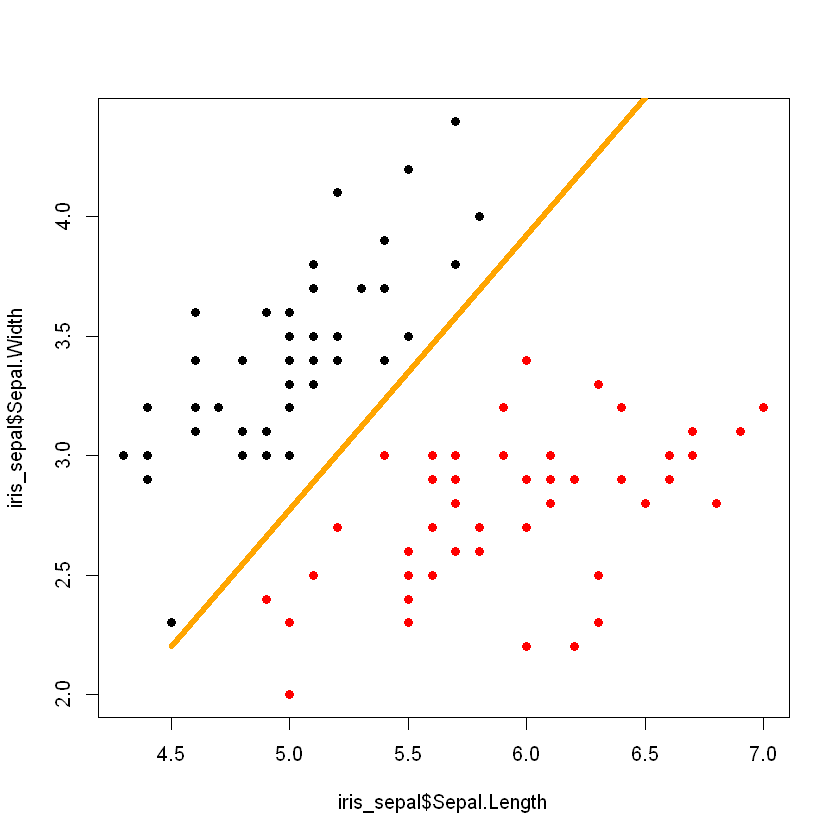

In [13]:
plot ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
lines ( c(4.5,6.5),c(2.2,4.5) , col = "orange", lty = 1, lwd = 5)


This is very much similar to the pizza example - right ? Let't fit this with **svm**.



In [15]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , data = iris_sepal)

In [17]:
y_pred  = predict(model, iris_sepal)

In [19]:
library(caret)

cm = confusionMatrix(y_pred,iris_sepal$Species)
cm

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa         49          0         0
  versicolor      1         50         0
  virginica       0          0         0

Overall Statistics
                                          
               Accuracy : 0.99            
                 95% CI : (0.9455, 0.9997)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.98            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                 0.9800            1.0000               NA
Specificity                 1.0000            0.9800                1
Pos Pred Value              1.0000            0.9804               NA
Neg Pred Value              0.9804            1.0000               NA
P

That's a 100% accuracy which is to be expected anyway (as we can visually see a straight line clearly separating the data points).

In [25]:
model$index

[1]  2  9 15 16 21 26 32 37 42 46 51 58 60 61 69 71 85 86 89

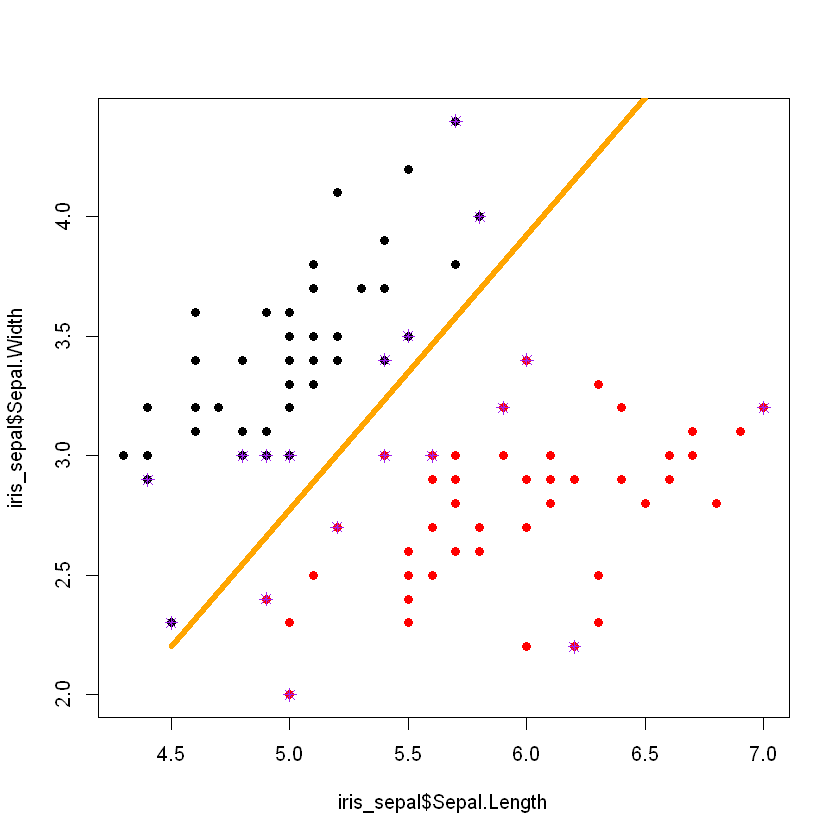

In [27]:
plot ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
lines ( c(4.5,6.5),c(2.2,4.5) , col = "orange", lty = 1, lwd = 5)

points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")


Ths straight line is basically centering itself based on the points that the kernel has identified as **support vectors** - shown in the plot above with **+** marks.

In [30]:
model$kernel

# 1 - Linear Kernel
# 2 - Polynomial Kernel
# 3 - Radial Basis Kernel
# 4 - Sigmoid Kernel

[1] 2

<hr>

### Case 2 - Clear Linear Separation not possible in 2D

The previous example was very simple. Let's take a more complicated example. One where SVM shines.



<img src="./pics/svm_urban-sub-urban.jpg"/>

Say each point is identified by a GPS location. Now, given a new location, can you classify it as urban or sub-urban ? Of course, you can use KNN for this. However, there is going to be a bit of an overlap - and of course the issues that we discussed earlier. SVM could potentially be an alternative.Let's see how.



Of course in this case linear modeling does not work - for the simple reason that the boundary is non-linear. So, how does SVM solve the problem ? Here goes.. Don't be scared.



> SVM projects the data into higher dimensional space to achieve linear separation. SVM essentially converts a non-linearly separable space into linearly separable space. 

I know, that's a lot to grasp. Let's break it down visually.

Let's imagine an A4 sheet of paper. and start to pull the corners of the paper upward. Imagine all the GPS data points on the A4 sheet of paper. and when we pull the corners upward and look at the whole paper sideways, what you see is a visual like this.

<img src="./pics/svm_project_into_higher_dimensions.jpg"/>

The corners are being pulled in the "z" direction. The urban homes are in the center of the paper and the sub-urban homes are on the edges. Since you are pulling the edges on the z-axis, the sub-urban homes are higher up on the z axis than the urban homes.



<img src="./pics/pull_corners_a4-Paper.jpg"/>

<img src="./pics/svm_data_points_center_edges.jpg"/>

Now, we can just draw a plan that clearly separates the sub-urban homes from the urban homes as shown below.



<img src="./pics/svm_hyperplane.jpg"/>

If you look at this picture from the top ( looking in the z-axis direction from the top ), you would be able to visualize a picture like this.



What is more important is the nature of the plane. Although the separating boundary between the points is a jagged circle, the separating plane is just a square plane that achieves linear separation between the two datasets based on the z- distance. Essentially, a non-linearly separable problem just became linearly separable ( in the z-axis ) by projecting the points into the 3rd dimension ( z-axis ). This is called as a Hyper plane - which we are going to talk about next.



<hr>

#### Significant overlap in the 2D space

Some times even if we project the data into a 3rd dimension ( or higher dimension ) there might not be a clear separation of data. We can very well see it in our simple iris datase for the other species - Virginica and Versicolor - These are very interspersed.



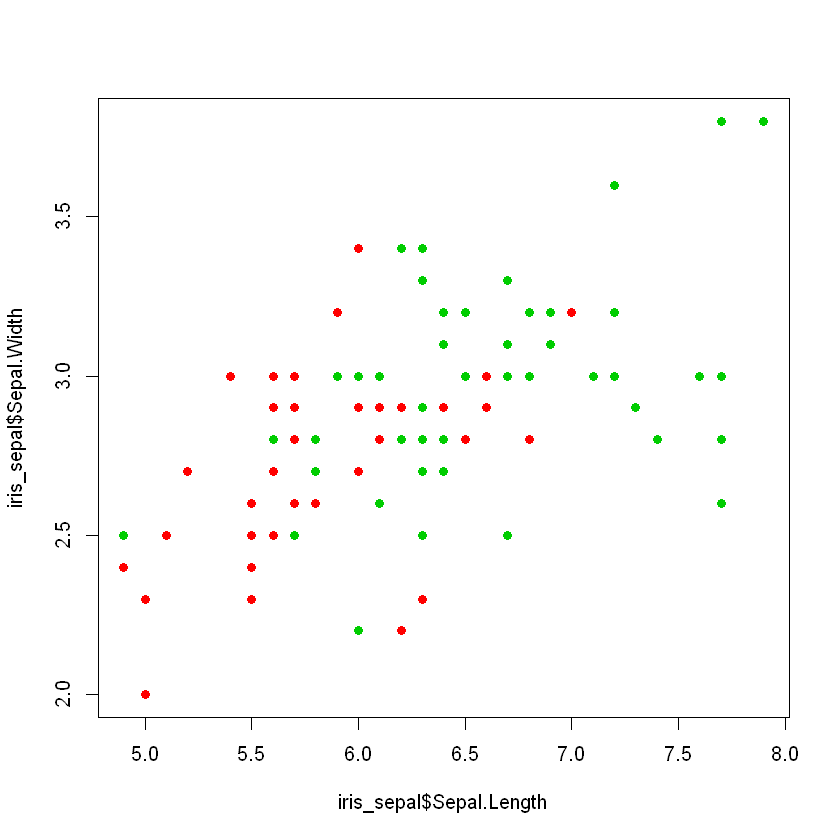

In [42]:
iris_sepal = iris[51:150,]
plot ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)

SVM will still be able to do a decent job with the separation. Let's code it.



In [36]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , data = iris_sepal)

In [37]:
y_pred  = predict(model, iris_sepal)

In [38]:
library(caret)

cm = confusionMatrix(y_pred,iris_sepal$Species)
cm

Confusion Matrix and Statistics

            Reference
Prediction   setosa versicolor virginica
  setosa          0          0         0
  versicolor      0         34        10
  virginica       0         16        40

Overall Statistics
                                          
               Accuracy : 0.74            
                 95% CI : (0.6427, 0.8226)
    No Information Rate : 0.5             
    P-Value [Acc > NIR] : 8.337e-07       
                                          
                  Kappa : 0.48            
                                          
 Mcnemar's Test P-Value : NA              

Statistics by Class:

                     Class: setosa Class: versicolor Class: virginica
Sensitivity                     NA            0.6800           0.8000
Specificity                      1            0.8000           0.6800
Pos Pred Value                  NA            0.7727           0.7143
Neg Pred Value                  NA            0.7143           0.7727
P

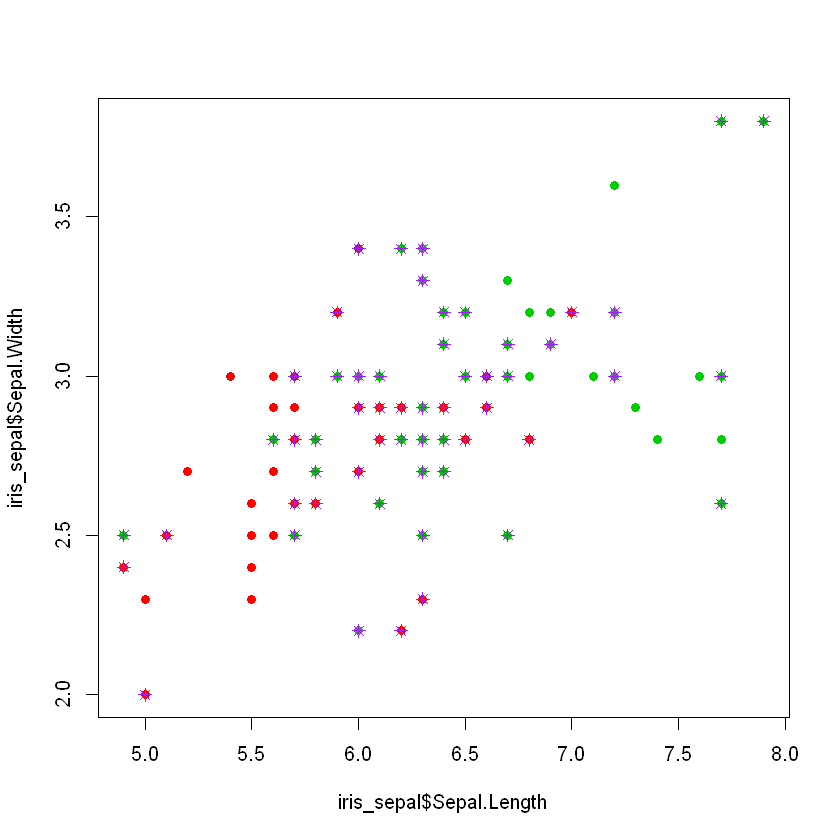

In [43]:
plot ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)

# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

That's an accuracy score of 73% - not bad, given the overlap. To plot the decision line/curve though, we need to take the help of the meshgrid. What we are essentially doing is create a mesh of data that spans the entire x-y axis. Technically, it is called as a **meshgrid**. We can use the readymade function **meshgrid ( )** from the **pracma** library.

In [148]:
mgrid = function ( x, y, l = 100 ) {
    library(pracma) # needed to create a meshgrid

    x = seq(from = min(x), to = max(x), length = l)
    y = seq(from = min(y), to = max(y), length = l)
    
    mg = meshgrid(x = x, y = y)    
    
    return ( mg )
}

If we plot the data, this is how it looks. 

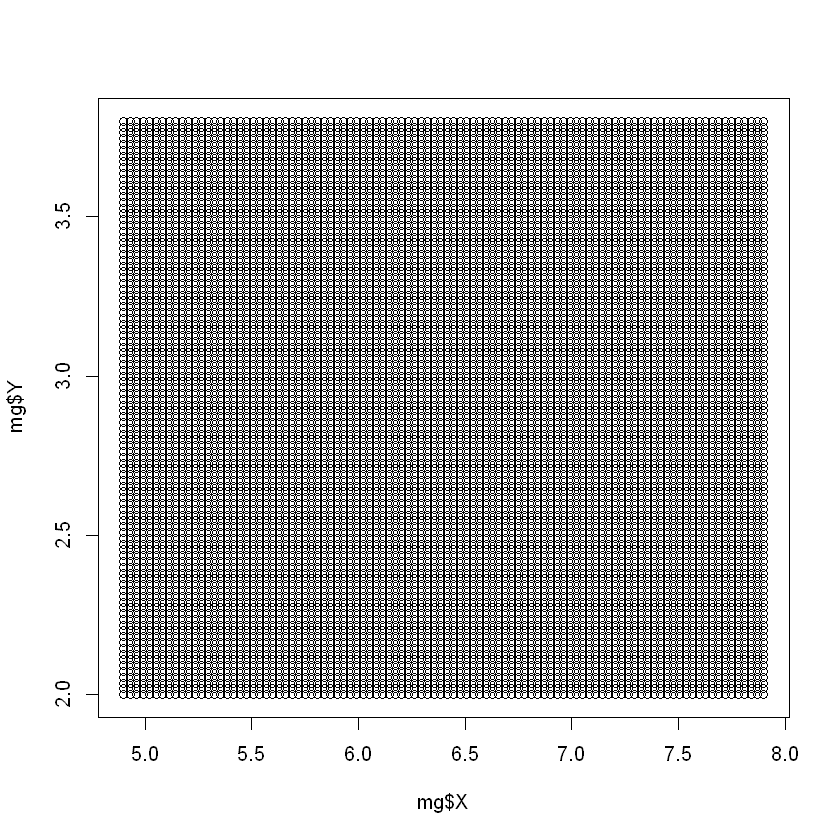

In [149]:
mg = mgrid ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width )
plot ( mg$X, mg$Y )

It is essentially a grid of all possible points. We just convert this matrix to a dataframe. 

In [151]:
df_mg = data.frame ( Sepal.Length  = list(as.vector(mg$X)), Sepal.Width = list(as.vector(mg$Y)) )

In [152]:
names(df_mg) = c("Sepal.Length", "Sepal.Width")
head(df_mg)

,Sepal.Length,Sepal.Width
,<dbl>,<dbl>
1,4.9,2.000000
2,4.9,2.018182
3,4.9,2.036364
4,4.9,2.054545
5,4.9,2.072727
6,4.9,2.090909


Now that we have the grid of data in a dataframe, let's predict all the points based on the model. 

In [153]:
y_pred  = predict(model, newdata = df_mg)

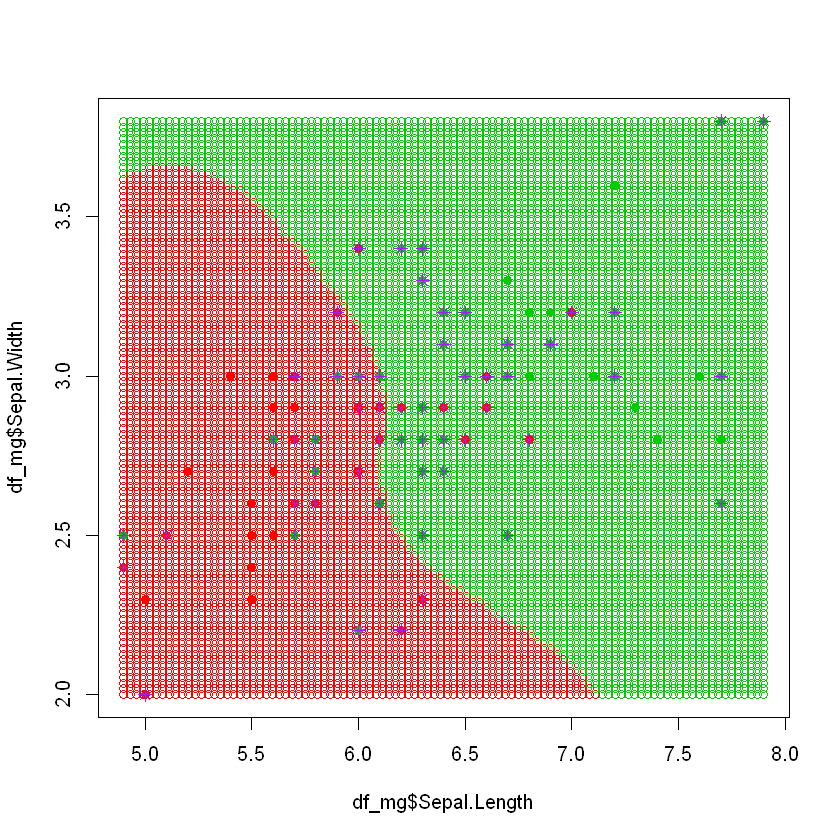

In [160]:
plot ( df_mg$Sepal.Length, df_mg$Sepal.Width, col = y_pred)

# these are the actual data points
points ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

This is based on a **linear kernel**. There are a couple more options for specifying the kernel. Scikit learn by default provides the following kernels in SVM. 

- linear
- rbf - Radial Basis Function
- poly - Polynomial


Let's actually try all of these to see how well the separator works. 

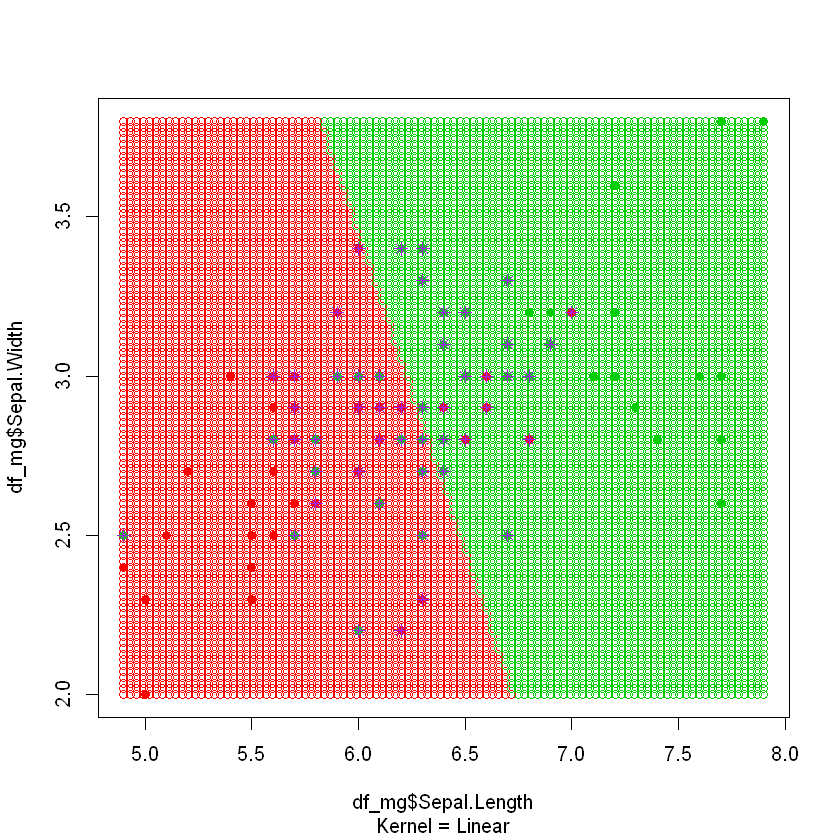

In [168]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , 
              data = iris_sepal, 
              kernel = "linear")
y_pred  = predict(model, newdata = df_mg)
plot ( df_mg$Sepal.Length, df_mg$Sepal.Width, col = y_pred, sub = "Kernel = Linear")

# these are the actual data points
points ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

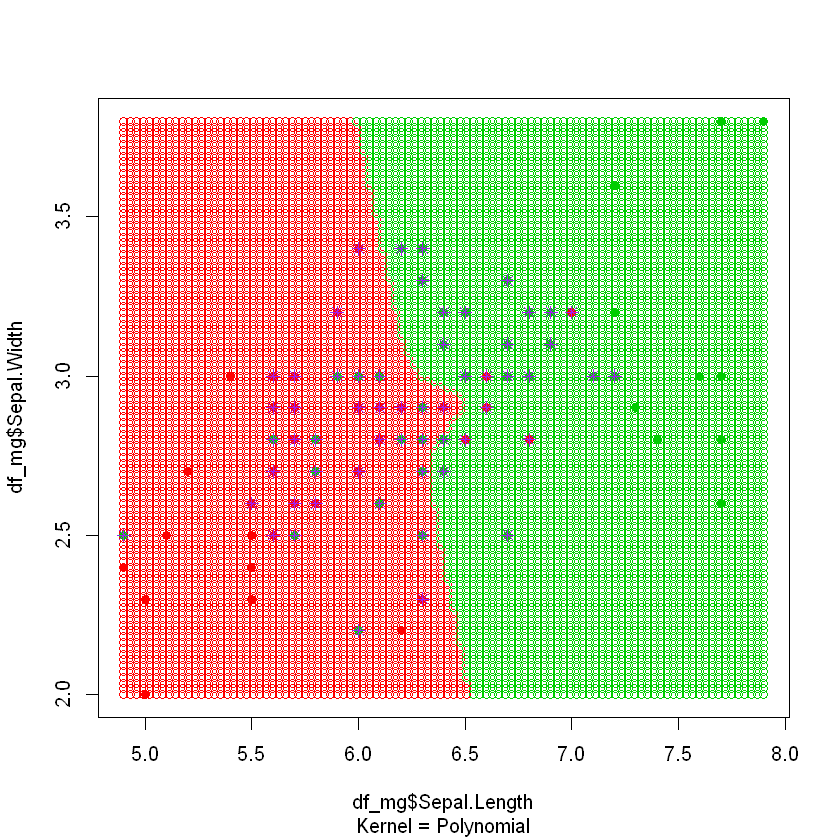

In [167]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , 
              data = iris_sepal, 
              kernel = "polynomial")
y_pred  = predict(model, newdata = df_mg)
plot ( df_mg$Sepal.Length, df_mg$Sepal.Width, col = y_pred, sub = "Kernel = Polynomial")

# these are the actual data points
points ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

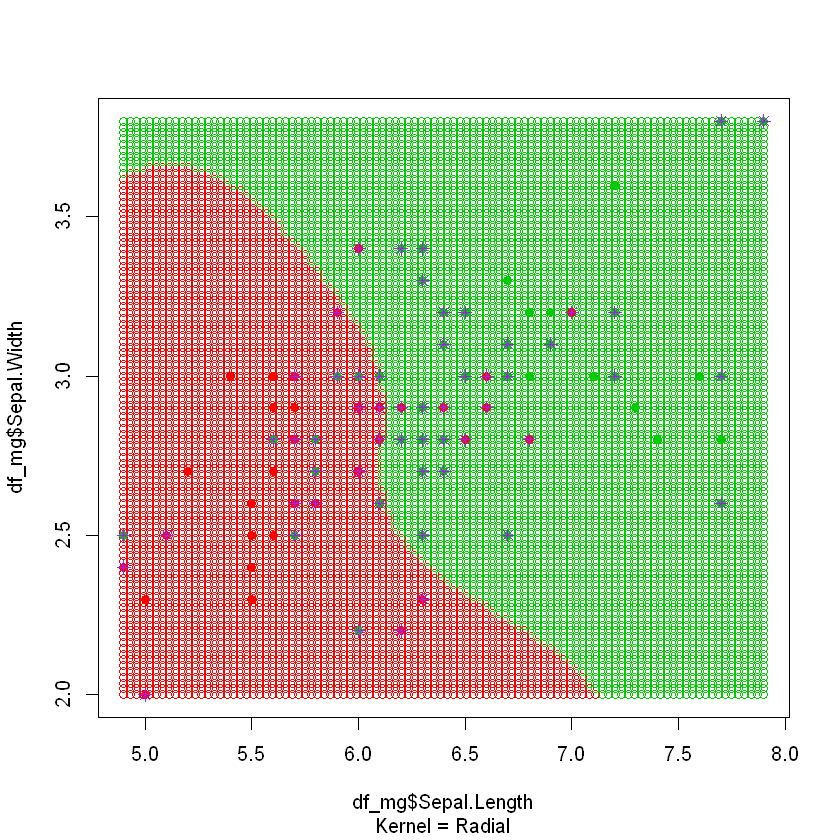

In [166]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , 
              data = iris_sepal, 
              kernel = "radial")
y_pred  = predict(model, newdata = df_mg)
plot ( df_mg$Sepal.Length, df_mg$Sepal.Width, col = y_pred, sub = "Kernel = Radial")

# these are the actual data points
points ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

Here is how the different SVM kernels compare.

<img src="./pics/classification-boundaries.png"/>

As you can see, there are a lot of support vectors this time ( + symbols in the plot above ) as the separating plane is pretty non-linear even in higher dimensional space. How did SVM do this ?



<hr>

### Hyperplane

To understand how SVM has done this, we have to first understand what a Hyperplane is. You see this word thrown out a lot in SVM. We cannot visualize hyperplane beyond 3 dimensions. However, a hyperplane is a (n-1) dimensional space in a n dimensional space. For example,



- a line ( 1-D ) is a hyperplane in a 2-D space.
- a 2-D plane is a hyperplane in a 3-D space.


It basically separates the space into 2 halves. I am over-simplifying it, but you get the idea.



> By projecting the data into a higher dimensional space SVM is able to derive a hyper plane that does a clear separation of the data points. This is the crux of the math behind SVM. 


<hr>

### Performance Tuning

There are basically 3 parameters for performance tuning. We have already seen one of them - the **kernel**. We will talk about the remaining two now. 

#### Cost

This parameter controls the balance between Accuracy and Stability. Outliers are good examples to illustrate this. Look at the picture below.



<img src="./pics/svm_outlier.jpg"/>

Because of an outlier in the setosa species, SVM is trying to fit it to the hyper plane. In all probability it is an outlier. This "over-fit" could result in the model de-stabilizing to make the model more accurate. Basically, you have to tell the model to go easy on data points like that. This is where the cost function comes in. What does a cost function do ? If we lower the costs function, more support vectors are included, resulting in a stable fit.



<img src="./pics/svm_outlier_c_value.jpg"/>

**Low Cost** - A lower cost value ( say c = 0.1 ) will result in more support vectors being included in determining the line. So, the outlier ( in green ) is basically ignored. This is also called "soft margin" and this avoids over-fitting.



**High Cost** - A higher cost value ( say c = 1 or 10 ) will try to accomodate the outlier ( bold, green dot in the picture above ) and it adjusts the hyper plane accordingly. This is also called "hard margin" and results in over-fit ( crisper and narrower fit ).



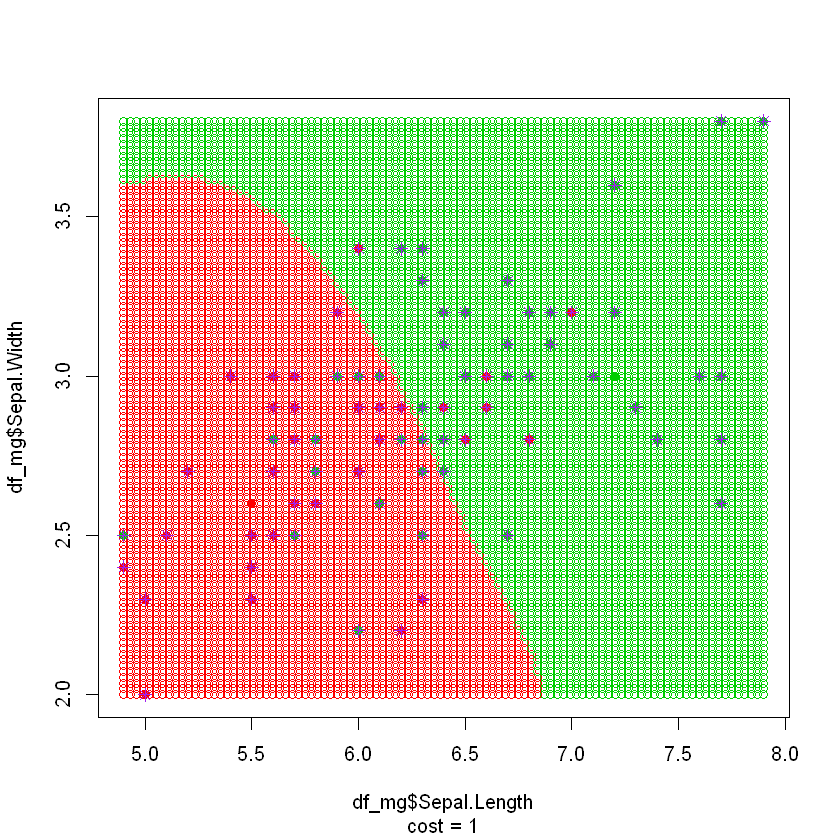

In [183]:
library(e1071)
model = svm ( Species ~ Sepal.Length + Sepal.Width , 
              data = iris_sepal, 
              cost = 0.1)
y_pred  = predict(model, newdata = df_mg)
plot ( df_mg$Sepal.Length, df_mg$Sepal.Width, col = y_pred, sub = "cost = 1")

# these are the actual data points
points ( iris_sepal$Sepal.Length, iris_sepal$Sepal.Width, 
       col = iris_sepal$Species,
       pch = 19)
# these are the support vectors
points ( iris_sepal[model$index, 1], iris_sepal[model$index, 2], pch = 8, col = "purple")

A more visual example would illustrate this better.

<img src="./pics/c-value-svm.png"/>

Here is an implementation of the same iris dataset with different Cost function (C value) for Radial Basis function kernel.

<img src="./pics/cost-functions.png"/>

<hr>

#### Kernel

This is the heart of the SVM algorithm. Always think of SVM as a linear classification in higher dimensional space. When data is linearly separable, we don't even need SVM - Simple linear regression would do. The "kernel" is a mathematical function that is used to project the data to higher dimensional space. Mathematically, this is done using dot products and there are many types of kernel functions - polynomial, linear, radial, sigmoid etc. Luckily, we wouldn't have to learn all that math. The SVM algorithm chooses the kernel for us automatically. If you look at the model itself, you will understand what type of kernel was used in doing the classification.



This is a parameter that is rarely touched. But since this is the core of the hyperplane transformation, we have to understand the type of kernel that is being used.



<hr>

#### Gamma - γ

Gamma is a parameter that is used in non-linear kernel transformations. A large gamma (γ) will result in high bias and low variance and a small value will result in low bias and high variance. If you understand the gamma parameter, you would have to understand the formula used in a non-linear transform like a radial basis function. You can leave it for now.



These parameters ( cost, kernel, gamma ) are called Hyper Parameters.



<hr>

### SVM for Regression

Just with most classification models, SVM can also be used for regression. Let's quickly do a comparison between a regular linear model and SVM. This is to just prove that



- SVM can do regression ( as well as classification )


Let's take the Boston Housing data set.

In [187]:
library(mlbench)
data(BostonHousing)

We know from Introduction to Linear Regression in Python that one of the variables LSTAT has a linear relationship with the target (predictor) - MEDV (Median house price). 

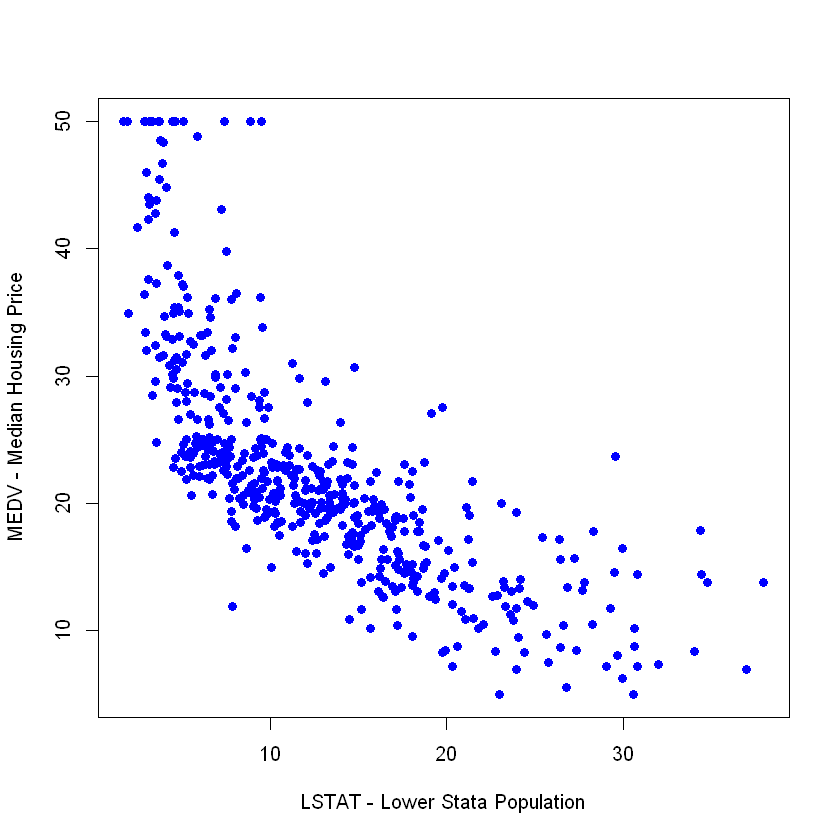

In [189]:
plot ( BostonHousing$lstat, BostonHousing$medv,
       xlab = "LSTAT - Lower Stata Population",
       ylab = "MEDV - Median Housing Price",
       pch  = 19,
       col  = "blue")


In this case the correlation is negative, but that's fine. Let's try to fit a linear model first and then compare it with SVM.


In [191]:
model_lin = lm ( medv ~ lstat, data = BostonHousing)
y_pred_lin = predict (model_lin, newdata = BostonHousing)

In [197]:
model_svm = svm ( medv ~ lstat, data = BostonHousing)
y_pred_svm = predict ( model_svm, newdata = BostonHousing)

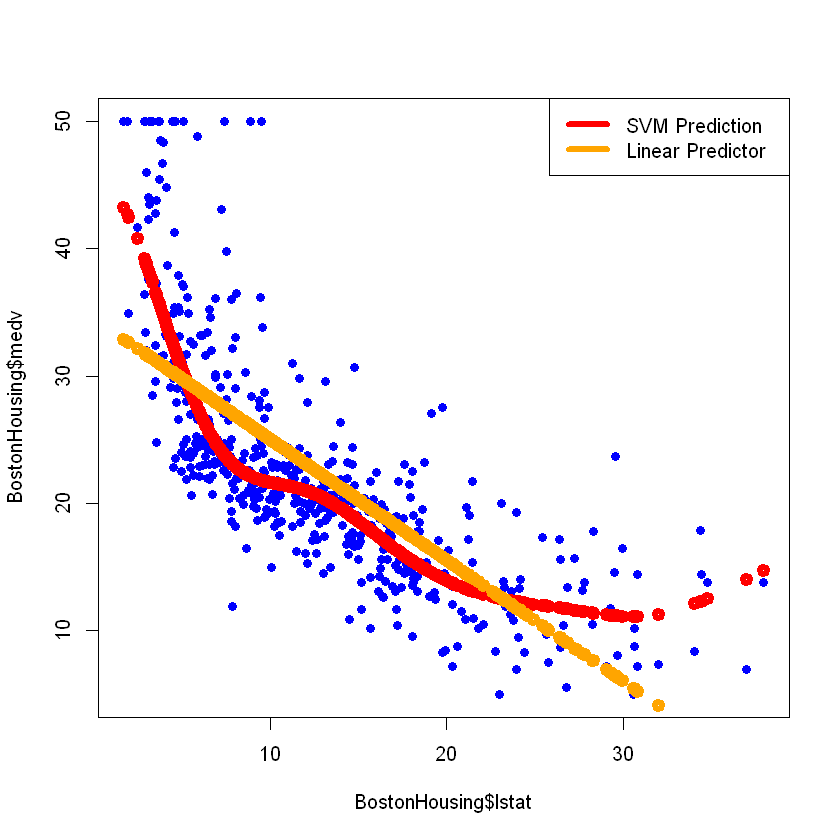

In [203]:
plot ( BostonHousing$lstat, BostonHousing$medv, pch = 19, col = "blue")
points ( BostonHousing$lstat, y_pred_svm, col = "red", lty = 1, lwd = 5)
points ( BostonHousing$lstat, y_pred_lin, col = "orange", lty = 1, lwd = 5)

legend ( "topright", legend = c("SVM Prediction", "Linear Predictor"), col = c("red","orange"), lty = 1, lwd = 5)